In [31]:
import pandas as pd
import numpy as np

In [32]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [64]:
import re

# Question using stops and ridership data

In [33]:
# reads teh csv files
stops = pd.read_csv('resources/CTA_-_System_Information_-_List_of__L__Stops.csv')
ridership = pd.read_csv('resources/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

In [34]:
stops

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,30106,S,Wilson (95th-bound),Wilson,Wilson (Red & Purple Lines),40540,True,True,False,False,False,False,False,False,False,False,"(41.964273, -87.657588)"
296,30383,N,Washington/Wabash (Outer Loop),Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700,True,False,False,True,True,False,False,False,False,False,"(41.88322, -87.626189)"
297,30385,S,Wilson (Loop-bound),Wilson,Wilson (Red & Purple Lines),40540,True,False,False,False,False,False,True,False,False,False,"(41.964273, -87.657588)"
298,30033,W,Ashland (Harlem-54th/Cermak-bound),Ashland,Ashland (Green & Pink Lines),40170,True,False,False,True,False,False,False,False,True,False,"(41.885269, -87.666969)"


In [35]:
ridership

,station_id,stationname,date,daytype,rides
0,40850,Library,10/09/2004,A,1057
1,40780,Central Park,06/18/2010,W,1154
2,41500,Montrose-Brown,10/30/2001,W,2116
3,40500,Washington/State,10/26/2006,W,0
4,41090,Monroe/State,07/07/2010,W,9431
...,...,...,...,...,...
1014879,41700,Washington/Wabash,06/26/2020,W,2095
1014880,41700,Washington/Wabash,06/27/2020,A,1526
1014881,41700,Washington/Wabash,06/28/2020,U,1189
1014882,41700,Washington/Wabash,06/29/2020,W,2152


In [36]:
# new df to compress the boolean columns using groupby() and any()
station_bools = stops[['MAP_ID', 'ADA', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y', 'Pnk', 'O']].groupby('MAP_ID').any()
# new df, drops unecessary columns and merges with previous df
stops = stops.drop(['STOP_ID', 'DIRECTION_ID', 'STOP_NAME',
'ADA','RED','BLUE','G','BRN','P','Pexp','Y','Pnk','O'], axis=1).merge(station_bools, how='left', left_on='MAP_ID',
right_index=True).drop_duplicates()
stops

,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,Location,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O
0,18th,18th (Pink Line),40830,"(41.857908, -87.669147)",True,False,False,False,False,False,False,False,True,False
2,35th/Archer,35th/Archer (Orange Line),40120,"(41.829353, -87.680622)",True,False,False,False,False,False,False,False,False,True
4,35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,"(41.831677, -87.625826)",True,False,False,True,False,False,False,False,False,False
6,43rd,43rd (Green Line),41270,"(41.816462, -87.619021)",True,False,False,True,False,False,False,False,False,False
8,51st,51st (Green Line),40130,"(41.80209, -87.618487)",True,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Cermak-McCormick Place,Cermak-McCormick Place (Green Line),41690,"(41.853115, -87.626402)",True,False,False,True,False,False,False,False,False,False
289,Wilson,Wilson (Red & Purple Lines),40540,"(41.964273, -87.657588)",True,True,False,False,False,False,True,False,False,False
290,Addison,Addison (Blue Line),41240,"(41.94738, -87.71906)",True,False,True,False,False,False,False,False,False,False
292,Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700,"(41.88322, -87.626189)",True,False,False,True,True,False,True,False,True,True


In [37]:
# separates location into long and lat, converts to strings
stops[['latitude','longitude']] = stops['Location'].str.replace('\(|\)','', regex=True).str.split(',',expand=True).apply(pd.to_numeric)
stops

,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,Location,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,latitude,longitude
0,18th,18th (Pink Line),40830,"(41.857908, -87.669147)",True,False,False,False,False,False,False,False,True,False,41.857908,-87.669147
2,35th/Archer,35th/Archer (Orange Line),40120,"(41.829353, -87.680622)",True,False,False,False,False,False,False,False,False,True,41.829353,-87.680622
4,35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,"(41.831677, -87.625826)",True,False,False,True,False,False,False,False,False,False,41.831677,-87.625826
6,43rd,43rd (Green Line),41270,"(41.816462, -87.619021)",True,False,False,True,False,False,False,False,False,False,41.816462,-87.619021
8,51st,51st (Green Line),40130,"(41.80209, -87.618487)",True,False,False,True,False,False,False,False,False,False,41.802090,-87.618487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Cermak-McCormick Place,Cermak-McCormick Place (Green Line),41690,"(41.853115, -87.626402)",True,False,False,True,False,False,False,False,False,False,41.853115,-87.626402
289,Wilson,Wilson (Red & Purple Lines),40540,"(41.964273, -87.657588)",True,True,False,False,False,False,True,False,False,False,41.964273,-87.657588
290,Addison,Addison (Blue Line),41240,"(41.94738, -87.71906)",True,False,True,False,False,False,False,False,False,False,41.947380,-87.719060
292,Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700,"(41.88322, -87.626189)",True,False,False,True,True,False,True,False,True,True,41.883220,-87.626189


In [38]:
# merge stops and ridership iusing left join
df = pd.merge(ridership, stops, how = 'left', left_on = 'station_id', right_on = 'MAP_ID')
df

,station_id,stationname,date,daytype,rides,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,Location,ADA,...,BLUE,G,BRN,P,Pexp,Y,Pnk,O,latitude,longitude
0,40850,Library,10/09/2004,A,1057,Harold Washington Library-State/Van Buren,Harold Washington Library-State/Van Buren (Bro...,40850.0,"(41.876862, -87.628196)",True,...,False,False,True,False,True,False,True,True,41.876862,-87.628196
1,40780,Central Park,06/18/2010,W,1154,Central Park,Central Park (Pink Line),40780.0,"(41.853839, -87.714842)",True,...,False,False,False,False,False,False,True,False,41.853839,-87.714842
2,41500,Montrose-Brown,10/30/2001,W,2116,Montrose,Montrose (Brown Line),41500.0,"(41.961756, -87.675047)",True,...,False,False,True,False,False,False,False,False,41.961756,-87.675047
3,40500,Washington/State,10/26/2006,W,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41090,Monroe/State,07/07/2010,W,9431,Monroe,Monroe (Red Line),41090.0,"(41.880745, -87.627696)",False,...,False,False,False,False,False,False,False,False,41.880745,-87.627696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036232,41700,Washington/Wabash,06/26/2020,W,2095,Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700.0,"(41.88322, -87.626189)",True,...,False,True,True,False,True,False,True,True,41.883220,-87.626189
1036233,41700,Washington/Wabash,06/27/2020,A,1526,Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700.0,"(41.88322, -87.626189)",True,...,False,True,True,False,True,False,True,True,41.883220,-87.626189
1036234,41700,Washington/Wabash,06/28/2020,U,1189,Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700.0,"(41.88322, -87.626189)",True,...,False,True,True,False,True,False,True,True,41.883220,-87.626189
1036235,41700,Washington/Wabash,06/29/2020,W,2152,Washington/Wabash,"Washington/Wabash (Brown, Green, Orange, Purpl...",41700.0,"(41.88322, -87.626189)",True,...,False,True,True,False,True,False,True,True,41.883220,-87.626189


In [39]:
# create new column to determine if South by using 41.881 latitude cutoff
df['south_side'] = df['latitude'] < 41.881
# find average rides for south side
df[['south_side', 'rides']].groupby('south_side').mean()

,rides
south_side,
False,3661.353244
True,2965.705764


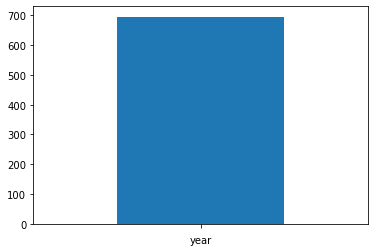

In [40]:
# convert date column to a datetime data type, create new column for just year
# calculate mean rides per station, grouping by year and side
df['year'] = ''
rides_by_sides = df[['year','south_side','rides']].groupby(['year','south_side']).mean().reset_index().pivot(index='year',columns='south_side',values='rides')
rides_by_sides.columns = ['north','south']
(rides_by_sides['north'] - rides_by_sides['south']).plot(kind='bar')

# Question using Census_Data.sqlite

In [41]:
# create engine, parameter is location of SQLite database file
engine = create_engine('sqlite:///Census_Data.sqlite')
# set up a foundation for us to build on in SQLAlchemy
Base = automap_base()
# reflect the schema from the tables to our code
Base.prepare(engine, reflect=True)
# checks if Automap was able to find all the data in our SQLite database
Base.classes.keys()


[]

In [42]:
#session link
#session = Session(engine)

In [43]:
#results = session.query(Base)
query = 'Select * from Census_Data'
census_df = pd.read_sql_query(query, engine)
census_df.head()

,CityState,city,state,Population,White Population,Black Population,Native American Population,Asian Population,Hispanic Population,Education None,...,Employment Female Computer Engineering,Median Age,Median Male Age,Median Female Age,Household Income,Income Per Capita,Median Gross Rent,Median Home Value,lat,lng
0,"HOUSTON, TX",HOUSTON,TX,3061887,1775897,684416,11586,230549,1368287,54180,...,22637,33.439583,32.550000,34.363542,56206.50000,32239.52083,956.708333,178233.6842,29.775734,-95.414548
1,"CHICAGO, IL",CHICAGO,IL,2702091,1318869,843633,7554,161478,785374,32800,...,18209,34.526786,33.798214,35.141071,57735.96429,38730.83929,1119.928571,264739.2857,41.867838,-87.673440
2,"BROOKLYN, NY",BROOKLYN,NY,2595259,1126111,870465,8744,297890,509243,48934,...,14845,35.175676,33.367568,36.578378,51469.18919,28309.67568,1261.783784,605743.2432,40.652805,-73.956528
3,"LOS ANGELES, CA",LOS ANGELES,CA,2426413,1068202,324842,15949,273829,1292382,62684,...,12329,35.335484,34.535484,36.061290,47494.58333,30073.19355,1201.766667,557115.0000,34.042209,-118.303468
4,"MIAMI, FL",MIAMI,FL,1820704,1361009,363514,2250,33144,1162711,27137,...,6969,38.740741,37.120370,40.262963,51232.90741,25949.35185,1260.833333,243279.6296,25.760268,-80.298511


In [63]:
# query for cities with pop over 100,000, which one has youngest median age?
query1 = 'select * from Census_Data where Population > 100000'
median_100k = pd.read_sql_query(query1, engine)
median_100k.sort_values('Median Age', ascending = True)

,CityState,city,state,Population,White Population,Black Population,Native American Population,Asian Population,Hispanic Population,Education None,...,Employment Female Computer Engineering,Median Age,Median Male Age,Median Female Age,Household Income,Income Per Capita,Median Gross Rent,Median Home Value,lat,lng
357,"PROVO, UT",PROVO,UT,115828,102237,715,511,3029,19980,511,...,623,23.833333,24.266667,23.266667,41659.33333,17196.00000,754.333333,206733.3333,40.253223,-111.633250
337,"ATHENS, GA",ATHENS,GA,120952,79691,31036,229,5350,12845,919,...,1079,25.316667,24.600000,26.050000,34224.25000,13672.66667,769.000000,143325.0000,33.958987,-83.383005
301,"BLOOMINGTON, IN",BLOOMINGTON,IN,130817,112800,4066,534,8715,4237,399,...,805,25.883333,25.433333,26.400000,39554.00000,17150.00000,834.250000,167000.0000,39.163813,-86.524614
376,"COLLEGE STATION, TX",COLLEGE STATION,TX,112074,89674,7634,244,9757,16374,333,...,1108,25.900000,25.150000,26.750000,45896.00000,23598.00000,985.500000,180150.0000,30.585239,-96.299284
260,"COLUMBIA, MO",COLUMBIA,MO,146510,116562,14311,351,6818,5310,500,...,1522,26.925000,26.575000,27.250000,45988.33333,20099.25000,801.666667,170500.0000,38.939703,-92.313594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,"TOMS RIVER, NJ",TOMS RIVER,NJ,122901,110183,4161,123,4547,10702,793,...,369,50.466667,47.800000,52.533333,60359.66667,33418.66667,1283.000000,236000.0000,39.976654,-74.211090
394,"VERO BEACH, FL",VERO BEACH,FL,108337,92955,11177,207,1502,9596,856,...,549,52.083333,50.666667,53.400000,53672.66667,38095.50000,933.833333,199466.6667,27.655137,-80.468874
127,"SARASOTA, FL",SARASOTA,FL,238533,215488,13610,591,3960,26506,1422,...,1153,52.107692,50.592308,53.484615,56700.23077,37958.30769,1115.153846,258384.6154,27.314415,-82.485241
96,"NAPLES, FL",NAPLES,FL,292357,259793,18119,541,3978,69650,3526,...,660,52.342857,51.321429,53.157143,61924.92857,43661.50000,1144.642857,324835.7143,26.170920,-81.723113


# Question using dracula.txt

In [70]:
dracula_df = pd.read_csv('resources/dracula.txt', sep='\n', header=None)
dracula_df.columns = ['text']

# regex expression to find words that come after 'vampire'
p = r'(?<=\bvampire\s)(\w+)'
dracula_df['text'].str.extractall(p, flags=re.I)[0].value_counts()

sleep      3
in         2
kind       1
can        1
meant      1
which      1
baptism    1
is         1
live       1
was        1
coming     1
of         1
Name: 0, dtype: int64